#EECS 442 PS5: Generative Adversarial Models

__Please provide the following information__
(e.g. Jinfan Zhou, zjf):




# Starting

Run the following code to import the modules you'll need. After you finish the assignment, remember to run all cells and convert the notebook to a .pdf file for Gradescope submission.

In [1]:
# !pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.2.1+cu118
Torchvision Version:  0.17.1+cu118
Using the GPU!


# Problem 6.1 pix2pix
You will build pix2pix for image translation.

In this question, you will need to:

1. Contruct dataloaders for train/test datasets
2. Build Generator and Discriminator
3. Train pix2pix and visualize the results during training
4. Plot the loss of generator/discriminator v.s. iteration
5. Design your own shoes (optional)

![](https://drive.google.com/uc?export=view&id=1Xsz_Hhtb2QUoYJ5XnLLnf4rwe_Wk7o2u)

## Step 0: Downloading the dataset.

We first download the `mini-edges2shoes` dataset sampled from the original `edges2shoes` dataset. The `mini-edges2shoes` dataset contains 1,000 training image pairs, and 100 testing image pairs.

There's nothing you need to implement for this part.

In [2]:
# Download the mini-edges2shoes dataset
# !rm -r mini-edges2shoes.zip
# !rm -r mini-edges2shoes
# !wget http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
# !unzip -q mini-edges2shoes.zip

# !nvidia-smi

## Step 1: Build dataloaders for train and test

We will first build dataloaders with PyTorch built-in classes. Here we build a Custom Dataset rather than a built-in dataset.

In [3]:
class Edges2Image(Dataset):
  def __init__(self, root_dir, split='train', transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """

    self.transform = transform

    self.files = glob.glob(os.path.join(root_dir, split, '*.jpg'))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.files[idx])
    img = np.asarray(img)
    if self.transform:
        img = self.transform(img)
    return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

###########################################################################
# TODO: Construct the dataloader                                          #
# For the train_loader, please use a batch size of 4 and set shuffle True #
# For the val_loader, please use a batch size of 5 and set shuffle False  #
# Hint: You'll need to create instances of the class above, name them as  #
# tr_dt and te_dt. The dataloaders should be named as train_loader and    #
# test_loader. You also need to include transform in your class           #
#instances                                                                #
###########################################################################

tr_dt = Edges2Image(root_dir="mini-edges2shoes", split='train', transform=transform)
te_dt = Edges2Image(root_dir="mini-edges2shoes", split='val', transform=transform)

train_loader = DataLoader(tr_dt, batch_size=4, shuffle=True)
test_loader = DataLoader(te_dt, batch_size=5, shuffle=True)

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

# Make sure that you have 1,000 training images and 100 testing images before moving on
print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

Number of training images 1000, number of testing images 100


/home/umhws/anaconda3/envs/eecs442/lib/python3.10/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


250
20
torch.Size([5, 3, 256, 256])


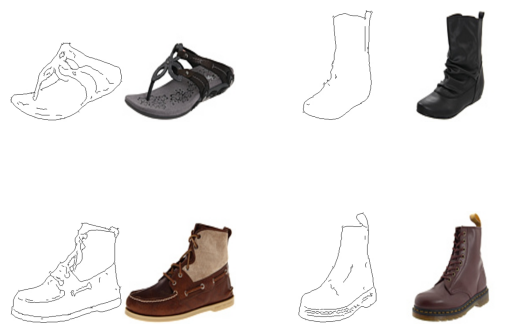

In [4]:
#Sample Output used for visualization
test = test_loader.__iter__().__next__()
img_size = 256
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  example = std * example + mean
  axes[i].imshow(example)
  axes[i].axis('off')
plt.show()

## Step 2: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

C512-C512-C512-C512-C256-C128-C64-C3

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

We have already implemented the U-net architecture below.

In [5]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()
    # delete end

In [6]:
class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()

    # Unet generator encoder
    self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(512)
    self.conv5 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
    self.bn5 = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(512)
    self.conv7 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
    self.bn7 = nn.BatchNorm2d(512)
    self.conv8 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)

    # Unet generator decoder

    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
    self.dbn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
    self.dbn2 = nn.BatchNorm2d(512)
    self.deconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
    self.dbn3 = nn.BatchNorm2d(512)
    self.deconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
    self.dbn4 = nn.BatchNorm2d(512)
    self.deconv5 = nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1)
    self.dbn5 = nn.BatchNorm2d(256)
    self.deconv6 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)
    self.dbn6 = nn.BatchNorm2d(128)
    self.deconv7 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
    self.dbn7 = nn.BatchNorm2d(64)
    self.deconv8 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):

    # encoding

    e1 = F.leaky_relu(self.conv1(input), negative_slope=0.2)
    e2 = F.leaky_relu(self.bn2(self.conv2(e1)), negative_slope=0.2)
    e3 = F.leaky_relu(self.bn3(self.conv3(e2)), negative_slope=0.2)
    e4 = F.leaky_relu(self.bn4(self.conv4(e3)), negative_slope=0.2)
    e5 = F.leaky_relu(self.bn5(self.conv5(e4)), negative_slope=0.2)
    e6 = F.leaky_relu(self.bn6(self.conv6(e5)), negative_slope=0.2)
    e7 = F.leaky_relu(self.bn7(self.conv7(e6)), negative_slope=0.2)
    e8 = F.leaky_relu(self.conv8(e7), negative_slope=0.2)

    # decoding

    d1 = F.relu(self.dbn1(self.deconv1(e8)))
    d1 = torch.cat([d1, e7], 1)
    d2 = F.relu(self.dbn2(self.deconv2(d1)))
    d2 = torch.cat([d2, e6], 1)
    d3 = F.relu(self.dbn3(self.deconv3(d2)))
    d3 = torch.cat([d3, e5], 1)
    d4 = F.relu(self.dbn4(self.deconv4(d3)))
    d4 = torch.cat([d4, e4], 1)
    d5 = F.relu(self.dbn5(self.deconv5(d4)))
    d5 = torch.cat([d5, e3], 1)
    d6 = F.relu(self.dbn6(self.deconv6(d5)))
    d6 = torch.cat([d6, e2], 1)
    d7 = F.relu(self.dbn7(self.deconv7(d6)))
    d7 = torch.cat([d7, e1], 1)
    d8 = F.tanh(self.deconv8(d7))

    output = d8

    return output

class discriminator(nn.Module):
  # initializers
  def __init__(self):
    super(discriminator, self).__init__()

    self.conv1 = nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(512)
    self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):

    x1 = F.leaky_relu(self.conv1(input))
    x2 = F.leaky_relu(self.bn2(self.conv2(x1)), negative_slope=0.2)
    x3 = F.leaky_relu(self.bn3(self.conv3(x2)), negative_slope=0.2)
    x4 = F.leaky_relu(self.bn4(self.conv4(x3)), negative_slope=0.2)
    x5 = F.sigmoid(self.conv5(x4))

    x = x5

    return x

In [7]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 51

In [8]:
D

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [9]:
G

generator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), paddin

## Step 3: Train

In this section, We will complete the training function. Then train our model. Below are some helper function that can be used. We will guide you through the implementation.



In [10]:
# Helper function for showing result.
def process_image(img):
  return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
  predict_images = G(x_)

  fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

  for i in range(x_.size()[0]):
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].get_yaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)
    ax[i, 1].get_yaxis().set_visible(False)
    ax[i, 2].get_xaxis().set_visible(False)
    ax[i, 2].get_yaxis().set_visible(False)
    ax[i, 0].cla()
    ax[i, 0].imshow(process_image(x_[i]))
    ax[i, 1].cla()
    ax[i, 1].imshow(process_image(predict_images[i]))
    ax[i, 2].cla()
    ax[i, 2].imshow(process_image(y_[i]))

  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Input'
  fig.text(0.18, 1, label_input, ha='center')
  label_output = 'Output'
  fig.text(0.5, 1, label_output, ha='center')
  label_truth = 'Ground truth'
  fig.text(0.81, 1, label_truth, ha='center')

  plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
  '''
  Counts the number of trainable parameters in PyTorch.
  Args:
      model: PyTorch model.
  Returns:
      num_params: int, number of trainable parameters.
  '''
  num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
  return num_params

## Objective Functions: Conditional Pix2Pix GAN

Given a generator $G$ and a discriminiator $D$, the loss function / objective functions to be minimized are given by

$
\mathcal{L}_{cGAN}(G, D) = \frac{1}{N} \left(\: \sum_{i=1}^{N} log D(x_i, y_i) + \sum_{i=1}^{N} log (1 - D\:(\:G\:(x_i),\: y_i) \:) \right)
$

where $(x_i, y_i)$ refers to the pair to the ground-truth input-output pair and $G(x_i)$ refers to the image translated by the Generator.

$
\mathcal{L}_{L1}(G, D) = \frac{1}{N} \sum_{i=1}^{N} \|\:y - G(x_i) \:\|_1
$

The final objective is just a combination of these objectives.

$
\mathcal{L}_{final}(G, D) = \mathcal{L}_{cGAN}(G, D) + λ \:\mathcal{L}_{L1}(G, D)
$

$
G^* = \underset{G}{\mathrm{argmin}} \:\underset{D}{\mathrm{max}}\; \mathcal{L}_{final}(G, D)
$

You would be implementing these objectives using the `nn.BCELoss` and `nn.L1Loss` as given below.


In [11]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20):
  hist_D_losses = []
  hist_G_losses = []
  hist_G_L1_losses = []
  ###########################################################################
  # TODO: Add Adam optimizer to generator and discriminator                 #
  # You will use lr=0.0002, beta=0.5, beta2=0.999                           #
  ###########################################################################

  G_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
  D_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  print('training start!')
  start_time = time.time()
  for epoch in range(num_epochs):
    print('Start training epoch %d' % (epoch + 1))
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for x_ in train_loader:
      y_ = x_[:, :, :, img_size:]
      x_ = x_[:, :, :, 0:img_size]

      x_, y_ = x_.cuda(), y_.cuda()
      ###########################################################################
      # TODO: Implement training code for the discriminator.                    #
      # Recall that the loss is the mean of the loss for real images and fake   #
      # images, and made by some calculations with zeros and ones               #
      # We have defined the BCE_loss, which you might would like to use.        #
      #                                                                         #
      # NOTE: While training the Discriminator, the output of the generator     #
      # must be detached from the computational graph. Refer to the method      #
      # torch.Tensor.detach()                                                   #
      ###########################################################################
      N = x_.shape[0]
      # Generate data
      fake_data = G.forward(x_).detach()
      
      #1. Train the discriminator
      # D real data BCE loss
      D_real_preds = D.forward(torch.cat((x_, y_), dim=1))
      D_y_real = torch.ones_like(D_real_preds)
      # D_real_loss = torch.sum(torch.log(D_real_preds))
      D_real_loss = BCE_loss(D_real_preds, D_y_real)

      # D fake data BCE loss
      D_fake_preds = D.forward(torch.cat((x_, fake_data), dim=1))
      D_y_fake = torch.zeros_like(D_fake_preds)
      # D_fake_loss = torch.sum(torch.log(1 - D_fake_preds))
      D_fake_loss = BCE_loss(D_fake_preds, D_y_fake)

      # D loss
      loss_D = D_real_loss + D_fake_loss
      
      # Train D
      D_optimizer.zero_grad()
      loss_D.backward()
      D_optimizer.step()

      ###########################################################################
      #                              END OF YOUR CODE                           #
      ###########################################################################

      ###########################################################################
      # TODO: Implement training code for the Generator.                        #
      ###########################################################################
      # Generate data
      fake_data = G.forward(x_)
      
      # 1. Train the generator
      # G BCE loss
      G_fake_preds = D.forward(torch.cat((x_, fake_data), dim=1))
      G_y_fake = torch.zeros_like(G_fake_preds)
      G_bce_loss = BCE_loss(G_fake_preds, G_y_fake)
      
      # G l1 loss
      G_l1_loss = L1_loss(fake_data, y_)
      
      # G loss
      lamb = 100
      loss_G = G_bce_loss +  lamb * G_l1_loss
      
      # Train G
      G_optimizer.zero_grad()
      loss_G.backward()
      G_optimizer.step()
      
      # 2. Append the losses to the lists 'hist_G_L1_losses' and 'hist_D_losses'
      #  (Only append the data to the list, not the complete tensor, refer
      #  torch.Tensor.item()).
      hist_G_losses.append(G_bce_loss.detach().item())
      hist_G_L1_losses.append(G_l1_loss.detach().item())
      ###########################################################################
      #                              END OF YOUR CODE                           #
      ###########################################################################

      D_losses.append(loss_D.detach().item())
      hist_D_losses.append(loss_D.detach().item())
      G_losses.append(loss_G)
      num_iter += 1



    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
    if epoch == 0 or (epoch + 1) % 5 == 0:
      with torch.no_grad():
        show_result(G, fixed_x_, fixed_y_, (epoch+1))

  end_time = time.time()
  total_ptime = end_time - start_time

  return hist_D_losses, hist_G_losses, hist_G_L1_losses

In this part, train your model with c=100 with at least 20 epochs.

In [12]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

training start!
Start training epoch 1
[1/20] - using time: 30.65 seconds
loss of discriminator D: 0.383
loss of generator G: 25.161


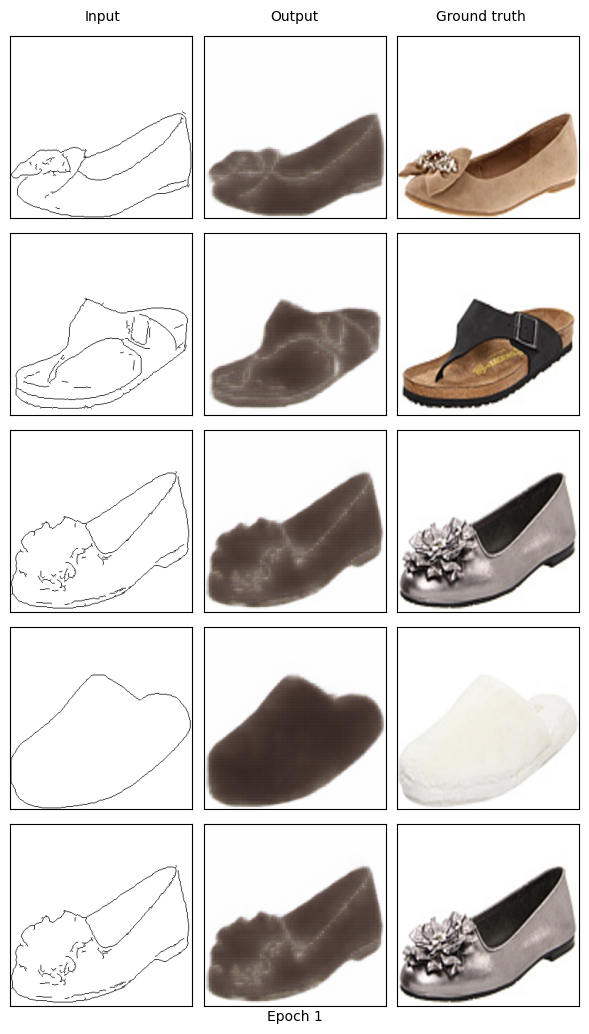

Start training epoch 2
[2/20] - using time: 30.63 seconds
loss of discriminator D: 0.757
loss of generator G: 18.413
Start training epoch 3
[3/20] - using time: 30.65 seconds
loss of discriminator D: 0.015
loss of generator G: 17.293
Start training epoch 4
[4/20] - using time: 30.62 seconds
loss of discriminator D: 0.228
loss of generator G: 16.499
Start training epoch 5
[5/20] - using time: 30.70 seconds
loss of discriminator D: 0.056
loss of generator G: 15.476


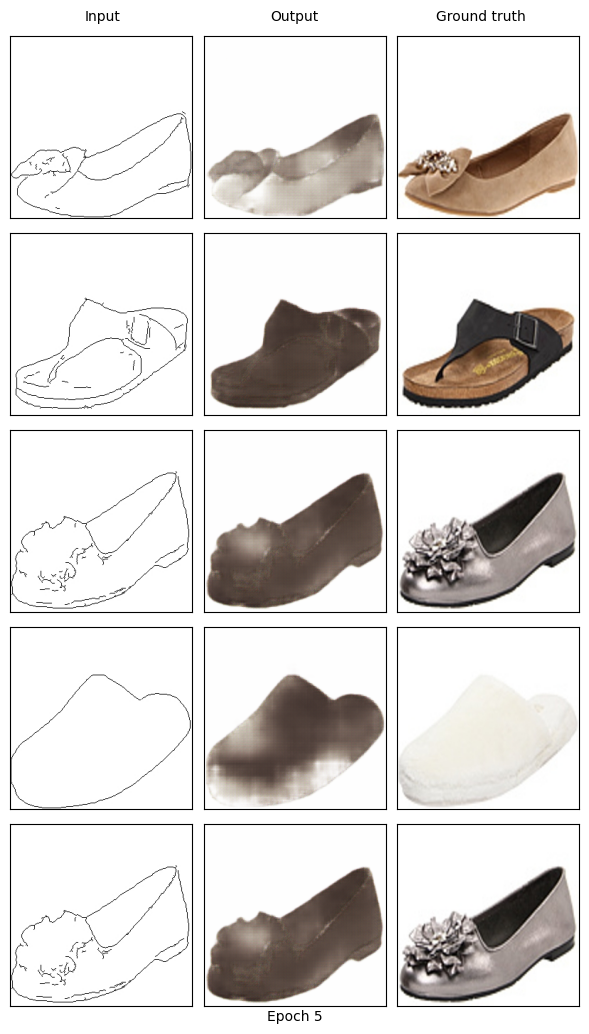

Start training epoch 6
[6/20] - using time: 30.67 seconds
loss of discriminator D: 0.045
loss of generator G: 14.544
Start training epoch 7
[7/20] - using time: 30.71 seconds
loss of discriminator D: 0.092
loss of generator G: 13.493
Start training epoch 8
[8/20] - using time: 30.70 seconds
loss of discriminator D: 0.090
loss of generator G: 12.859
Start training epoch 9
[9/20] - using time: 30.78 seconds
loss of discriminator D: 0.008
loss of generator G: 12.007
Start training epoch 10
[10/20] - using time: 30.83 seconds
loss of discriminator D: 0.092
loss of generator G: 11.815


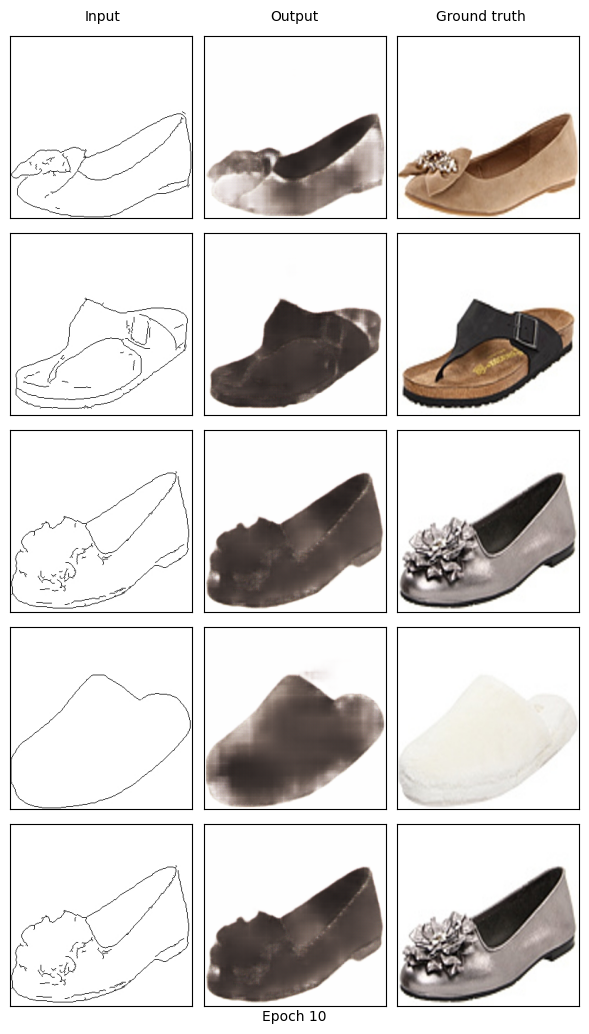

Start training epoch 11
[11/20] - using time: 30.74 seconds
loss of discriminator D: 0.072
loss of generator G: 11.080
Start training epoch 12
[12/20] - using time: 30.64 seconds
loss of discriminator D: 0.097
loss of generator G: 10.429
Start training epoch 13
[13/20] - using time: 30.72 seconds
loss of discriminator D: 0.005
loss of generator G: 9.857
Start training epoch 14
[14/20] - using time: 30.49 seconds
loss of discriminator D: 0.004
loss of generator G: 9.444
Start training epoch 15
[15/20] - using time: 30.68 seconds
loss of discriminator D: 0.036
loss of generator G: 9.071


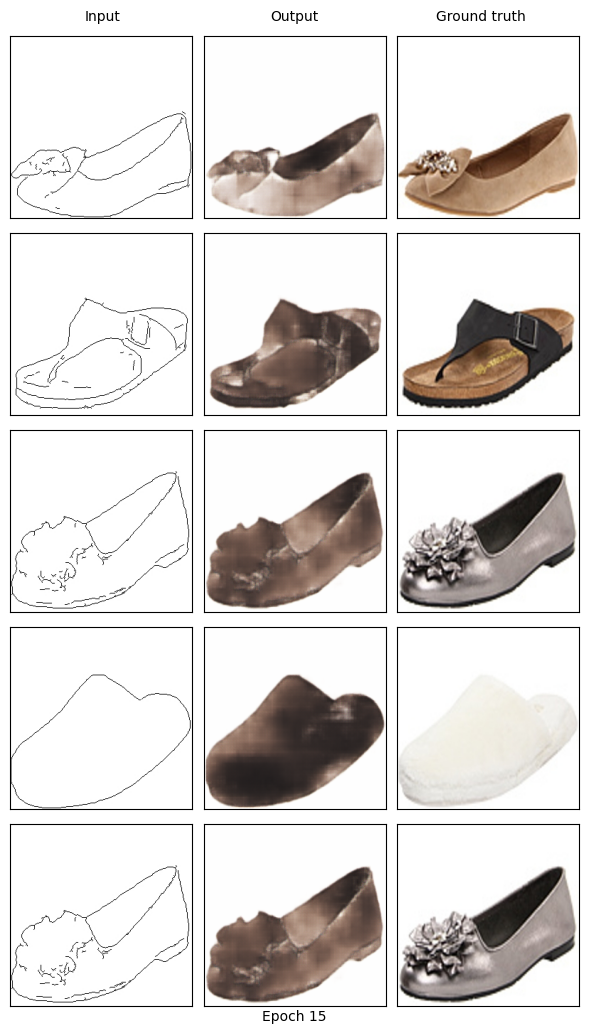

Start training epoch 16
[16/20] - using time: 30.81 seconds
loss of discriminator D: 0.027
loss of generator G: 8.602
Start training epoch 17
[17/20] - using time: 30.41 seconds
loss of discriminator D: 0.111
loss of generator G: 8.302
Start training epoch 18
[18/20] - using time: 30.71 seconds
loss of discriminator D: 0.023
loss of generator G: 8.026
Start training epoch 19
[19/20] - using time: 30.74 seconds
loss of discriminator D: 0.073
loss of generator G: 8.350
Start training epoch 20
[20/20] - using time: 30.70 seconds
loss of discriminator D: 0.006
loss of generator G: 7.689


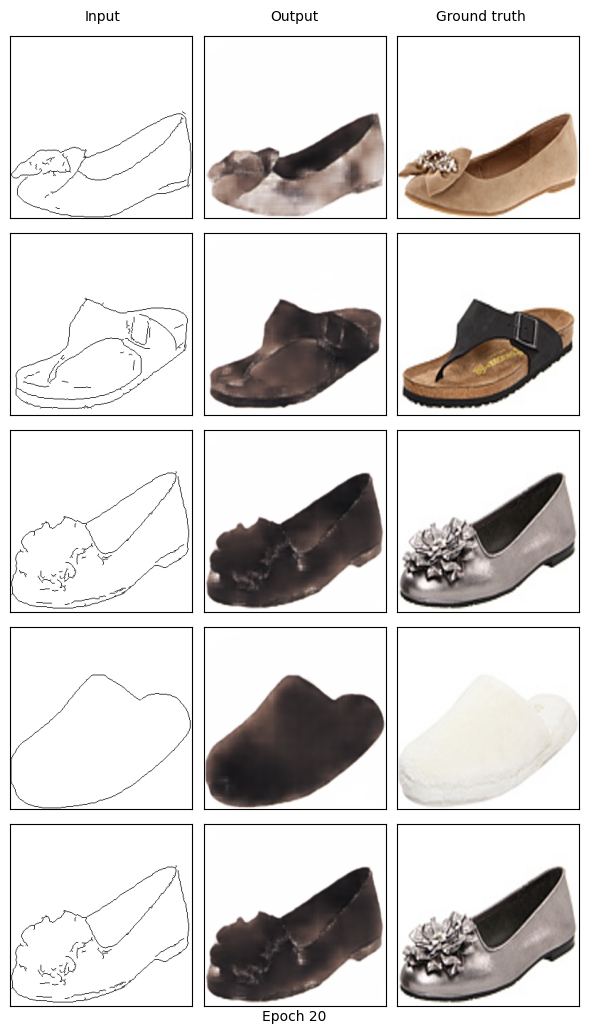

In [13]:
#training, you will be expecting 1-2 minutes per epoch.
# TODO: change_num_epochs if you want

hist_D_100_losses, hist_G_100_BCE_losses, hist_G_100_L1_losses = train(G=G_100, D=D_100, num_epochs=20)

In [14]:
!mkdir models
torch.save(G_100.state_dict(), './models/G_100.pth')
torch.save(D_100.state_dict(), './models/D_100.pth')

mkdir: cannot create directory ‘models’: File exists


The following cell saves the trained model parameters to your Google Drive so you could reuse those parameters later without retraining.

In [28]:
from google.colab import drive
drive.mount('/content/drive')
!cp "./models/" -r "/content/drive/My Drive/"

ModuleNotFoundError: No module named 'google'

## Step 4: Visualization



Please plot the generator BCE and L1 losses, as well as the discriminator loss. For this, please use c=100, and use 3 separate plots. We have provided the code for you and you only need to run the code below.

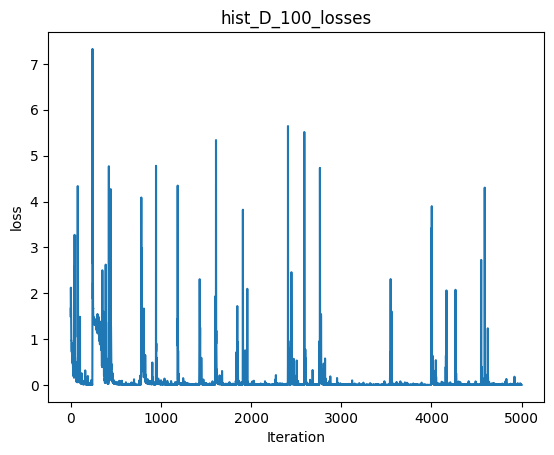

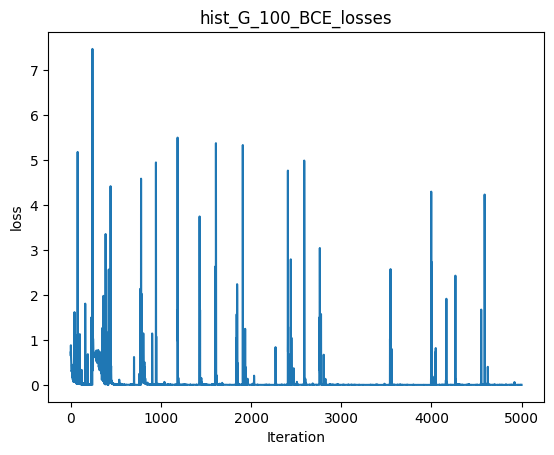

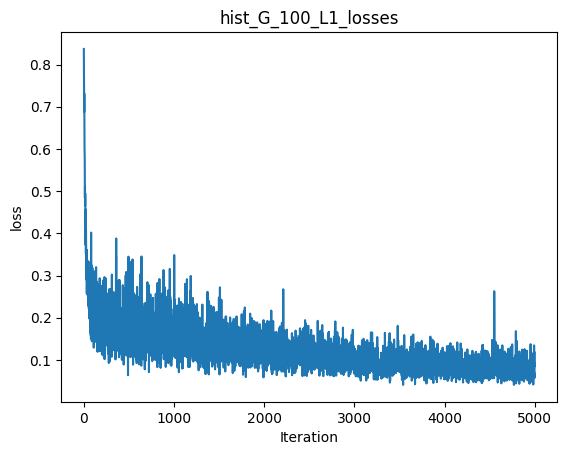

In [15]:
# Plot the G/D loss history (y axis) vs. Iteration (x axis)         #
# You will have three plots, with hist_D_100_losses,                      #
# hist_G_100_BCE_losses, hist_G_100_L1_losses respectively.               #

# hist_D_100_losses
plt.figure()
plt.plot(range(len(hist_D_100_losses)), torch.tensor(hist_D_100_losses, device = 'cpu'))
# plt.legend('hist_D_100_losses')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('hist_D_100_losses')
plt.show()


# hist_G_100_BCE_losses
plt.figure()
plt.plot(range(len(hist_G_100_BCE_losses)), torch.tensor(hist_G_100_BCE_losses, device = 'cpu'))
# plt.legend('hist_G_100_BCE_losses')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('hist_G_100_BCE_losses')
plt.show()

# hist_G_100_L1_losses
plt.figure()
plt.plot(range(len(hist_G_100_L1_losses)), torch.tensor(hist_G_100_L1_losses, device = 'cpu'))
# plt.legend('hist_G_100_L1_losses')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('hist_G_100_L1_losses')
plt.show()

# Convert Notebook to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [ ]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442-504_PS6_FA_2022_Starter_Code.ipynb'

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')